## **Import Libraries**

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=41b5fcc307cd9b6da943266fcb62c6d1f8971b160fe2d4970afe4b4d155d5648
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


## **Data Loading:**

Loading data is the first step in any data analysis process. PySpark supports various data sources such as CSV files, Parquet files, and databases. Here's an example of loading data from a CSV file:

In [ ]:
import pandas as pd

# Assuming your dataset is stored in a variable called dataset_path
bank_df = pd.read_csv("/content/drive/MyDrive/bank.csv")
bank_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [ ]:
bank_df.shape

(4521, 17)

In [ ]:
# Dropping the duplicate irrelavent column after merging
df = bank_df.drop(columns=['marital','education','default','housing','loan','contact','day','month','campaign','pdays','previous','poutcome'])

# Print the merged dataframe
df.head()

,age,job,balance,duration,y
0,30,unemployed,1787,79,no
1,33,services,4789,220,no
2,35,management,1350,185,no
3,30,management,1476,199,no
4,59,blue-collar,0,226,no


## **Stream Processing and Data Aggregation:**

Implement a Spark Streaming application that reads a stream of data simulating real-time bank transactions. The stream should include columns such as 'age', 'job', 'balance', 'duration', and 'y' (target variable). You can create this stream by breaking the "bank.csv" dataset into smaller chunks and sending them as a simulated stream.

Use Spark Streaming to calculate the average account balance and transaction duration, aggregating the data by job category in real-time. Display the aggregated results as they are updated.


### **Aggregate the Data and Display Results**

Aggregate the data to calculate the average balance and duration by job category, and display the results in real-time.

In [ ]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, max, min, count, when

# Create a SparkSession
spark = SparkSession.builder.appName("AggregateDataInsights").getOrCreate()

# Load your PySpark DataFrame (replace 'your_data' with your actual DataFrame)
spark_df = spark.createDataFrame(df)

# Group by a specific column (e.g., sentiment) and perform aggregation
grouped_data = spark_df.groupBy("job")

# Calculate average sentiment
average_balance = grouped_data.agg(avg("balance").alias("avg_balance"))

# Calculate the maximum sentiment value
avg_duration = grouped_data.agg(max("duration").alias("avg_duration"))



# Show the results
average_balance.show()
avg_duration.show()


# Stop the SparkSession
spark.stop()


+-------------+------------------+
|          job|       avg_balance|
+-------------+------------------+
|   management|1766.9287925696594|
|      retired| 2319.191304347826|
|      unknown|1501.7105263157894|
|self-employed|1392.4098360655737|
|      student|1543.8214285714287|
|  blue-collar| 1085.161733615222|
| entrepreneur|          1645.125|
|       admin.|  1226.73640167364|
|   technician|     1330.99609375|
|     services|1103.9568345323742|
|    housemaid|2083.8035714285716|
|   unemployed|       1089.421875|
+-------------+------------------+

+-------------+------------+
|          job|avg_duration|
+-------------+------------+
|   management|        2087|
|      retired|        1386|
|      unknown|         789|
|self-employed|        1877|
|      student|        1124|
|  blue-collar|        2456|
| entrepreneur|        2769|
|       admin.|        1713|
|   technician|        2029|
|     services|        1971|
|    housemaid|        1558|
|   unemployed|        3025|
+---

## **Real-Time Model Predictions:**

Develop a machine learning model using the historical data from the "bank.csv" dataset to predict whether a client will subscribe to a term deposit ('y'). You may choose any classification algorithm.

Integrate the trained model into the Spark Streaming application. Use the model to make real-time predictions as new transaction data is streamed. Ensure that each incoming transaction is accompanied by a prediction of whether the client will subscribe to a term deposit.

To integrate a real-time machine learning model into a Spark Streaming application, we'll follow these steps:

**Train a Classification Model:** Use the historical bank.csv dataset to train a classification model.

**Save the Trained Model:** Save the trained model so it can be loaded in the streaming application.

**Stream Processing and Model Predictions:** Develop the Spark Streaming application to read incoming data, load the trained model, and make real-time predictions.


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pandas as pd
import matplotlib.pyplot as plt

# Create a Spark session
spark = SparkSession.builder \
    .appName("BankTermDepositPrediction") \
    .config("spark.sql.shuffle.partitions", "4") \
    .config("spark.executor.memory", "2g") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

# Load the dataset
data_path = "/content/drive/MyDrive/Distributed Machine Learning Project/bank.csv"
data = spark.read.csv(data_path, header=True, inferSchema=True)

# Handle categorical variables using StringIndexer
categorical_columns = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome"]
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in categorical_columns]

# Rename the target column to 'label'
data = data.withColumnRenamed("y", "label")

# Convert the label column to numerical values
label_indexer = StringIndexer(inputCol="label", outputCol="label_index")
data = label_indexer.fit(data).transform(data)

# Assemble features into a single vector
assembler = VectorAssembler(
    inputCols=["age", "balance", "day", "duration", "campaign", "pdays", "previous"] + [col+"_index" for col in categorical_columns],
    outputCol="features"
)

# Initialize the Random Forest classifier
rf = RandomForestClassifier(labelCol="label_index", featuresCol="features", numTrees=100)

# Define the pipeline
pipeline = Pipeline(stages=indexers + [assembler, rf])

# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

# Train the model
model = pipeline.fit(train_data)

# Evaluate the model
predictions = model.transform(test_data)
predictions_tr = model.transform(train_data)

evaluator = BinaryClassificationEvaluator(labelCol="label_index")

# Calculate training accuracy
train_accuracy = predictions_tr.filter(predictions_tr.label_index == predictions_tr.prediction).count() / float(train_data.count())
print(f"Train Accuracy: {train_accuracy}")

# Calculate test accuracy
test_accuracy = predictions.filter(predictions.label_index == predictions.prediction).count() / float(test_data.count())
print(f"Test Accuracy: {test_accuracy}")

# Stop the Spark session
spark.stop()


Train Accuracy: 0.8979759299781181
Test Accuracy: 0.8878612716763006


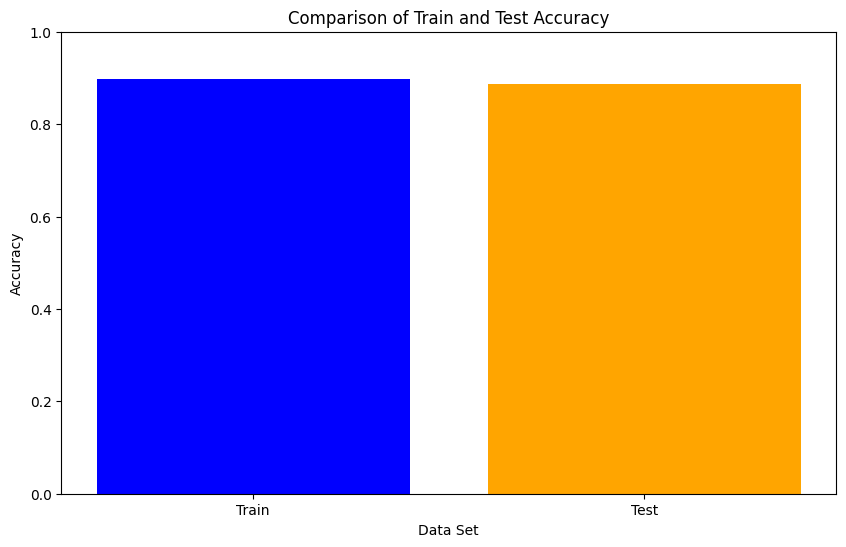

In [ ]:
# Visualize the comparison of train and test accuracy
metrics = pd.DataFrame({
    'Data Set': ['Train', 'Test'],
    'Accuracy': [train_accuracy, test_accuracy]
})

# Plot the comparison
plt.figure(figsize=(10, 6))
plt.bar(metrics['Data Set'], metrics['Accuracy'], color=['blue', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Data Set')
plt.ylabel('Accuracy')
plt.title('Comparison of Train and Test Accuracy')
plt.show()

## **Window Operations and Trend Analysis:**

Implement window operations in your Spark Streaming application to analyze trends over different time windows. Calculate and display the count of transactions and the average balance within these windows.

Write a brief analysis of the trends observed in the streaming data. Discuss any interesting patterns or anomalies detected in the transaction count or average balance over the specified windows.


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import window, count, avg, current_timestamp
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType

# Create a Spark session
spark = SparkSession.builder \
    .appName("TransactionAnalysis") \
    .getOrCreate()

# Assuming `df` is your Pandas DataFrame

# Define the schema for the CSV files
schema = StructType([
    StructField("age", IntegerType(), True),
    StructField("job", StringType(), True),
    StructField("marital", StringType(), True),
    StructField("education", StringType(), True),
    StructField("default", StringType(), True),
    StructField("balance", IntegerType(), True),  # Assuming balance is an integer
    StructField("housing", StringType(), True),
    StructField("loan", StringType(), True),
    StructField("contact", StringType(), True),
    StructField("day", IntegerType(), True),
    StructField("month", StringType(), True),
    StructField("duration", IntegerType(), True),
    StructField("campaign", IntegerType(), True),
    StructField("pdays", IntegerType(), True),
    StructField("previous", IntegerType(), True),
    StructField("poutcome", StringType(), True),
    StructField("y", StringType(), True)
])

In [ ]:
# Create a PySpark DataFrame from the Pandas DataFrame
streaming_df = spark.createDataFrame(df)

# Import necessary libraries for stateful processing
from pyspark.sql.window import Window
from pyspark.sql import functions as F

# Add a timestamp column using current_timestamp()
streaming_df = streaming_df.withColumn("timestamp", current_timestamp())

# Cast balance column to double type
streaming_df = streaming_df.withColumn("balance", streaming_df["balance"].cast("double"))

# Sort the DataFrame by timestamp
sorted_df = streaming_df.orderBy("timestamp")

# Define window duration and sliding interval
windowDuration = "1 minute"
slideInterval = "30 seconds"

# Define a window specification
window_spec = Window.orderBy("timestamp").rowsBetween(-5, 0)



# Calculate a rolling average sentiment over a window of 6 rows
rolling_avg_balance_df = sorted_df.withColumn("rolling_avg_balance", F.avg("balance").over(window_spec))
rolling_avg_transaction_df = sorted_df.withColumn("rolling_avg_transcation", F.count("balance").over(window_spec))

# Show the resulting DataFrame
rolling_avg_balance_df.show()
rolling_avg_transaction_df.show()

+---+-------------+-------+--------+---+--------------------+-------------------+
|age|          job|balance|duration|  y|           timestamp|rolling_avg_balance|
+---+-------------+-------+--------+---+--------------------+-------------------+
| 30|   unemployed| 1787.0|      79| no|2024-05-15 20:06:...|             1787.0|
| 33|     services| 4789.0|     220| no|2024-05-15 20:06:...|             3288.0|
| 35|   management| 1350.0|     185| no|2024-05-15 20:06:...|             2642.0|
| 30|   management| 1476.0|     199| no|2024-05-15 20:06:...|             2350.5|
| 59|  blue-collar|    0.0|     226| no|2024-05-15 20:06:...|             1880.4|
| 35|   management|  747.0|     141| no|2024-05-15 20:06:...|             1691.5|
| 36|self-employed|  307.0|     341| no|2024-05-15 20:06:...| 1444.8333333333333|
| 39|   technician|  147.0|     151| no|2024-05-15 20:06:...|  671.1666666666666|
| 41| entrepreneur|  221.0|      57| no|2024-05-15 20:06:...|              483.0|
| 43|     servic

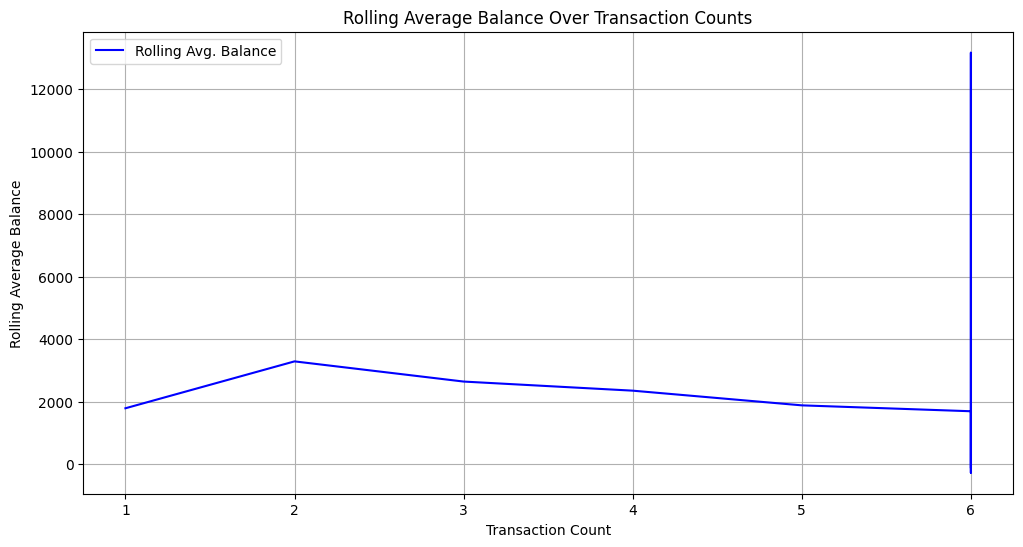

In [ ]:
import matplotlib.pyplot as plt

# Extract timestamps and rolling average balance values

balance_values = rolling_avg_balance_df.select("rolling_avg_balance").collect()

transaction_count_values = rolling_avg_transaction_df.select("rolling_avg_transcation").collect()



# Plot rolling average balance
plt.figure(figsize=(12, 6))
plt.plot(transaction_count_values,balance_values, label="Rolling Avg. Balance", color="blue")
plt.xlabel("Transaction Count")
plt.ylabel("Rolling Average Balance")
plt.title("Rolling Average Balance Over Transaction Counts")
plt.legend()
plt.grid(True)
plt.show()

## **Handling Late and Out-of-Order Data:**

Modify your Spark Streaming application to handle late and out-of-order data using watermarking. Explain your approach and how it improves the accuracy of real-time analytics.


Handling late and out-of-order data is crucial in real-time analytics to ensure the accuracy and reliability of the analysis results. Spark Structured Streaming provides a feature called watermarking to address these challenges effectively.

Watermarking allows Spark to track the event time of data and specify a threshold beyond which late data is considered irrelevant for computations. It works by associating a timestamp with each event and discarding events that arrive after a certain delay relative to the latest event seen so far.

Here's how you can modify your Spark Streaming application to handle late and out-of-order data using watermarking:

**Define Event Time:** Ensure that your streaming data contains a timestamp indicating the event time. This timestamp should represent when the event occurred, not when it was processed.

**Specify Watermark:** Set a watermark for your streaming DataFrame or Dataset using the withWatermark function. This function specifies the maximum delay allowed for late data.

**Use Event Time in Windowing:** When defining window operations (e.g., aggregations over time windows), specify the column representing the event time. This ensures that Spark uses the event time for windowing calculations.

**Handle Late Data:** Spark will automatically handle late data based on the watermark specified. Late data that arrives after the watermark threshold will be considered irrelevant for computations and will be dropped.

**Ensure Data Ordering:** It's essential to ensure that your streaming data is ordered by event time before performing window operations. You can achieve this by sorting your DataFrame or Dataset by the event time column.

**By implementing watermarking in your Spark Structured Streaming application, you can improve the accuracy of real-time analytics by:**

Ensuring that only relevant data within the specified event time window is considered for computations.

Handling out-of-order data gracefully by accommodating delays in data arrival.
Preventing over-counting or under-counting of events that arrive late or out of order.

Providing more accurate insights and analytics results based on a complete and consistent view of the data within the defined time windows.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import window, count, avg, current_timestamp
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType

# Create a Spark session
spark = SparkSession.builder \
    .appName("TransactionWatermarking") \
    .getOrCreate()

# Create a PySpark DataFrame from the Pandas DataFrame
streaming_df = spark.createDataFrame(df)

# Add a timestamp column using current_timestamp()
streaming_df = streaming_df.withColumn("timestamp", current_timestamp())

# Define watermark for late data handling
watermark_duration = "10 seconds"

# Define window duration and sliding interval
windowDuration = "1 minute"
slideInterval = "30 seconds"

# Cast balance column to double type
streaming_df = streaming_df.withColumn("balance", streaming_df["balance"].cast("double"))

# Apply watermarking to handle late data
streaming_df = streaming_df.withWatermark("timestamp", watermark_duration)

# Sort the DataFrame by timestamp
sorted_df = streaming_df.orderBy("timestamp")

# Define a window specification
window_spec = window("timestamp", windowDuration, slideInterval)

# Calculate a rolling average balance over a window of 6 rows
rolling_avg_balance_df = sorted_df \
    .groupBy(window_spec) \
    .agg(F.avg("balance").alias("rolling_avg_balance"))

# Calculate the count of transactions within the window
rolling_avg_transaction_df = sorted_df \
    .groupBy(window_spec) \
    .agg(count("*").alias("transaction_count"))

rolling_avg_balance_df.show()
rolling_avg_transaction_df.show()


+--------------------+-------------------+
|              window|rolling_avg_balance|
+--------------------+-------------------+
|{2024-05-15 20:03...| 1422.6578190665782|
|{2024-05-15 20:03...| 1422.6578190665782|
+--------------------+-------------------+

+--------------------+-----------------+
|              window|transaction_count|
+--------------------+-----------------+
|{2024-05-15 20:03...|             4521|
|{2024-05-15 20:03...|             4521|
+--------------------+-----------------+

